# Multivariate QuasiCopula GWAS with Mixed Marginals

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using Statistics
using StatsBase
using MendelPlots

BLAS.set_num_threads(1)

function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
    p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = 0
        while minor_alleles <= min_ma
            maf = 0.5rand()
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
        mafs[j] = maf
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

[ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]


_make_snparray (generic function with 1 method)

## Simulate data

Given $n$ independent samples, we simulate phenotypes from 
$$\mathbf{y}_i \sim QC(\mathbf{\Gamma}, f_1, ..., f_d)$$

In [229]:
# simulate data
p = 3    # number of fixed effects, including intercept
m = 2    # number of variance componentsac
n = 5000 # number of sample
d = 4    # number of phenotypes per sample
q = 1000 # number of SNPs
k = 5    # number of causal SNPs

# sample d marginal distributions for each phenotype within samples
Random.seed!(1234)
possible_distributions = [Bernoulli, Poisson]
vecdist = rand(possible_distributions, d)
# vecdist = [Poisson, Bernoulli, Bernoulli] # this derivative test is fine
# vecdist = [Bernoulli, Bernoulli, Poisson] # this derivative test is wrong everywhere
veclink = [canonicallink(vecdist[j]()) for j in 1:d]

# simulate nongenetic coefficient and variance component params
Random.seed!(2022)
Btrue = rand(Uniform(-0.5, 0.5), p, d)
θtrue = fill(0.4, m)
V1 = ones(d, d)
V2 = Matrix(I, d, d)
Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
# Γ = 0.5.*ones(d, d) + 0.5I

# simulate non-genetic design matrix
Random.seed!(2022)
X = [ones(n) randn(n, p - 1)]

# simulate random SnpArray with q SNPs and randomly choose k SNPs to be causal
# here the first phenotype has strong effect, while other phenotypes have decreasing effects
Random.seed!(2022)
G = simulate_random_snparray(undef, n, q)
Gfloat = convert(Matrix{Float64}, G, center=true, scale=true)
γtrue = zeros(q, d)
causal_snps = sample(1:q, k, replace=false) |> sort
γtrue[causal_snps, 1] .= rand([-0.2, 0.2], k)
for j in 2:d
    γtrue[causal_snps, j] .= 0.5^j .* γtrue[causal_snps, 1]
end

# sample phenotypes
Y = zeros(n, d)
y = Vector{Float64}(undef, d)
for i in 1:n
    Xi = X[i, :]
    Gi = Gfloat[i, :]
    η = Btrue' * Xi + γtrue' * Gi
    vecd_tmp = Vector{UnivariateDistribution}(undef, d)
    for j in 1:d
        dist = vecdist[j]
        μj = GLM.linkinv(canonicallink(dist()), η[j])
        vecd_tmp[j] = dist(μj)
    end
    multivariate_dist = MultivariateMix(vecd_tmp, Γ)
    res = Vector{Float64}(undef, d)
    rand(multivariate_dist, y, res)
    Y[i, :] .= y
end

# form model
V = m == 1 ? [V1] : [V1, V2]
qc_model = MultivariateCopulaVCModel(Y, X, V, vecdist, veclink, penalized=false);

What does phenotypes look like?

In [230]:
Y

5000×4 Matrix{Float64}:
 1.0  0.0  1.0  1.0
 0.0  1.0  0.0  0.0
 1.0  1.0  0.0  3.0
 0.0  5.0  0.0  0.0
 1.0  0.0  1.0  2.0
 1.0  2.0  1.0  1.0
 0.0  1.0  1.0  0.0
 0.0  1.0  1.0  1.0
 1.0  1.0  0.0  2.0
 0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0
 0.0  2.0  1.0  0.0
 ⋮              
 1.0  1.0  1.0  2.0
 0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0
 0.0  1.0  1.0  0.0
 1.0  3.0  1.0  0.0
 0.0  4.0  1.0  0.0
 1.0  0.0  0.0  2.0
 0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0
 0.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0
 1.0  3.0  1.0  1.0

What does our covariates look like?

In [231]:
X

5000×3 Matrix{Float64}:
 1.0  -0.308648    1.70162
 1.0   1.67671    -0.548034
 1.0  -0.347153    0.736227
 1.0   0.818666   -2.16009
 1.0  -1.71753    -0.273745
 1.0  -0.238934    0.942883
 1.0   0.701932    1.02868
 1.0  -0.166138   -0.278824
 1.0  -0.609614    0.289359
 1.0   0.68791     0.209478
 1.0   0.0342303  -0.543192
 1.0  -0.479078   -0.865401
 1.0  -1.63537     0.348029
 ⋮                
 1.0   0.200555    1.14607
 1.0  -0.205806    1.98172
 1.0   1.17812     0.307879
 1.0   1.60549     0.817788
 1.0   1.63509    -0.960082
 1.0  -0.446096   -1.0502
 1.0   0.632009   -0.335688
 1.0   0.589777   -1.92135
 1.0  -0.542628    1.68057
 1.0  -0.779274    0.6376
 1.0  -1.19111    -1.3064
 1.0   0.505272    1.11117

True SNP effects

In [232]:
γtrue[findall(!iszero, γtrue)]

20-element Vector{Float64}:
  0.2
  0.2
 -0.2
  0.2
 -0.2
  0.05
  0.05
 -0.05
  0.05
 -0.05
  0.025
  0.025
 -0.025
  0.025
 -0.025
  0.0125
  0.0125
 -0.0125
  0.0125
 -0.0125

Support for the phenotypes

In [233]:
vecdist

4-element Vector{UnionAll}:
 Bernoulli
 Poisson
 Bernoulli
 Poisson

In [234]:
# true Γ scaled to correlation matrix
cov2cor(Γ, diag(Γ))

4×4 Matrix{Float64}:
 1.0    0.625  0.625  0.625
 0.625  1.0    0.625  0.625
 0.625  0.625  1.0    0.625
 0.625  0.625  0.625  1.0

In [235]:
# empirical correlation of Y
Statistics.cor(Y)

4×4 Matrix{Float64}:
 1.0       0.126215   0.149685   0.10909
 0.126215  1.0        0.0952175  0.0194712
 0.149685  0.0952175  1.0        0.159768
 0.10909   0.0194712  0.159768   1.0

## Fit Null model

TODO: 

+ Initializing model parameters

In [236]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 100,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
        derivative_test="first-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Starting derivative checker for first derivatives.


No errors detected by derivative checker.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       14
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:  

In [237]:
@show qc_model.∇vecB
@show qc_model.∇θ;

qc_model.∇vecB = [-1.2467343239452866e-6, -1.3910790296056685e-6, 8.61692640047318e-6, -5.013526466868257e-6, -9.326385330910014e-6, -4.845416793353152e-6, -5.4444424315014395e-6, 1.4412081318387893e-5, 8.992787771111566e-7, -1.1980328428085052e-5, -7.714791836338497e-6, -6.990658495825697e-6]
qc_model.∇θ = [6.400263261596706e-6, 2.723714553454215e-6]


In [238]:
[vec(qc_model.B) vec(Btrue)]

12×2 Matrix{Float64}:
 -0.293093   -0.280755
  0.0985447   0.167603
 -0.336887   -0.330996
 -0.0575416  -0.0469412
  0.479354    0.483384
 -0.241677   -0.269155
  0.0987866   0.144784
 -0.399915   -0.39274
 -0.0239704   0.0260867
 -0.246693   -0.234534
 -0.0994702  -0.0969734
  0.105221    0.0955352

In [239]:
[qc_model.θ θtrue]

2×2 Matrix{Float64}:
 0.448731  0.4
 0.4528    0.4

In [240]:
qc_model.penalized

false

## Autodiff checks

First, check if `autodiff_loglikelihood` returns same answer as `QuasiCopula.loglikelihood!`

In [174]:
# define autodiff likelihood, gradient, and Hessians
autodiff_loglikelihood(vecB) = QuasiCopula.loglikelihood(vecB, qc_model, z)
∇logl = x -> ForwardDiff.gradient(autodiff_loglikelihood, x)
∇²logl = x -> ForwardDiff.hessian(autodiff_loglikelihood, x)
∇logl! = (grad, x) -> ForwardDiff.gradient!(grad, autodiff_loglikelihood, x)
∇²logl! = (hess, x) -> ForwardDiff.hessian!(hess, autodiff_loglikelihood, x)

# sample i loglikelihood
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
fullβ = [vec(qc_model.B); qc_model.θ; zeros(d)]
# fullβ = [qc_model.β; qc_model.θ; qc_model.τ; zeros(d)] # normal

@show autodiff_loglikelihood(fullβ)
@show QuasiCopula.loglikelihood!(qc_model, false, false);

autodiff_loglikelihood(fullβ) = -20292.905371821944
QuasiCopula.loglikelihood!(qc_model, false, false) = -20292.905371823275


Lets compute a few Hessians

In [175]:
i = 1
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 1

18×18 Matrix{Float64}:
 -632.823      -21.4738       30.4495   …    0.842171      2.619
  -21.4738    -604.98        -28.9684       -0.0413417     0.459265
   30.4495     -28.9684     -599.192         1.65776       1.17729
  107.556       41.3065      -28.293         1.4076        5.22071
   41.3065     113.606        -2.29752       0.762857      4.33628
  -28.293       -2.29752      99.0345   …    1.41269       0.356133
   60.9983       4.09349       2.22575      -0.829679      2.22235
    4.09349     59.3865       -0.81889       3.76708       0.186459
    2.22575     -0.81889      60.6271       -8.31407       1.00221
   93.7865       2.35496      -1.04703       2.22235       7.0849
    2.35496     92.9894        1.46748  …    0.186459     21.652
   -1.04703      1.46748      90.8038        1.00221     -34.7914
  -42.9543      11.3325      -31.0218       -6.19715     -11.582
    7.12722     40.8786      -34.154        -2.40134      -7.22885
    0.442875     2.08455      -7.08072      

In [176]:
i = 10
z = convert(Vector{Float64}, @view(G[:, i]), center=true, scale=false)
Hfull = ∇²logl(fullβ) # snp 10

18×18 Matrix{Float64}:
 -632.823      -21.4738     30.4495    …     0.814884      3.03618
  -21.4738    -604.98      -28.9684         -1.46681      -3.52215
   30.4495     -28.9684   -599.192           1.36703       2.85973
  107.556       41.3065    -28.293           0.828104      3.73736
   41.3065     113.606      -2.29752        -2.56424      -3.60895
  -28.293       -2.29752    99.0345    …    -3.35384      -2.05564
   60.9983       4.09349     2.22575         0.722096      3.42676
    4.09349     59.3865     -0.81889        -8.67499      -3.75257
    2.22575     -0.81889    60.6271          9.8269        1.92115
   93.7865       2.35496    -1.04703         3.42676      16.0439
    2.35496     92.9894      1.46748   …    -3.75257     -35.5145
   -1.04703      1.46748    90.8038          1.92115      54.5368
  -42.9543      11.3325    -31.0218          6.20733      22.9274
    7.12722     40.8786    -34.154          -3.13267      -8.8422
    2.444       -7.91854     5.69671        

Check gradient

In [177]:
∇logl(fullβ)

18-element Vector{Float64}:
 -3.288564031528329e-5
 -9.271545333505715e-6
  2.5569035333017354e-5
  2.2455003598265133e-5
  4.5558109538768043e-5
 -1.0415080668513266e-5
  2.4175350741728607e-5
  1.0144715449772468e-5
  2.7534773054116446e-5
 -9.233717258694263e-6
  9.01368769642974e-6
  2.3738441629062024e-5
  9.260687237166998e-6
  1.752613043420892e-5
  1.6516151672286656
 -9.828099348063088
 -3.374463632442021
 -1.6034035920967213

## Score test with autodiff

In [241]:
pvals = multivariateGWAS_autodiff(qc_model, G)

Progress: 100%|█████████████████████████████████████████| Time: 0:04:34


1000-element Vector{Float64}:
 0.7815742325229147
 0.17140268237304465
 0.002799776263036702
 0.5886764503637241
 0.7375897874583739
 0.7777517528510861
 0.1517370757806214
 0.6175342930512208
 0.3930267593234532
 0.1971264986648714
 0.8305456159265281
 0.21874324406128542
 0.5615837348998681
 ⋮
 0.6140791081327294
 0.635613436675311
 0.9155248770268267
 0.5589480805780602
 0.9283238396080231
 0.6407599910158946
 0.31450738799001743
 0.24252778005967757
 0.8581997586901977
 0.8377764392098912
 0.4441710734074863
 0.14544341160794663

Check QQ plots

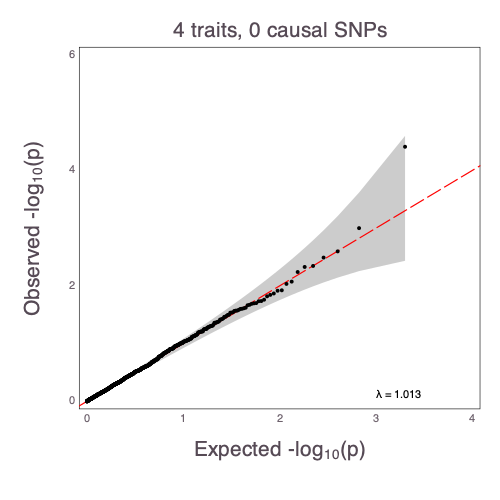

In [179]:
# only Poisson/Bernoulli traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

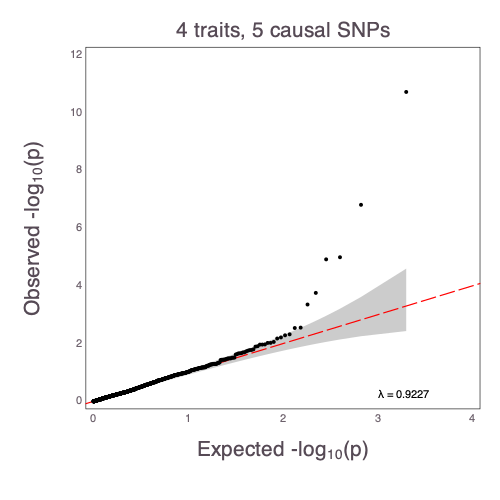

In [242]:
# only Poisson/Bernoulli traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

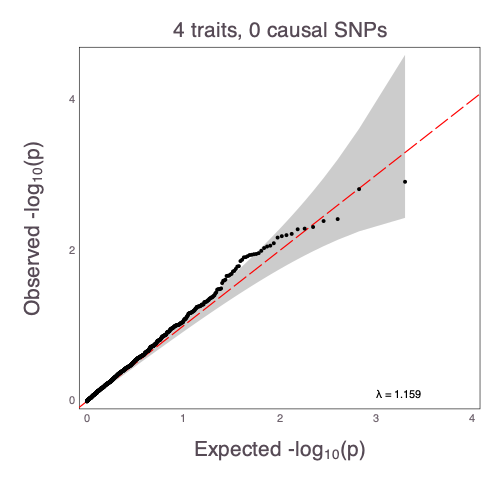

In [25]:
# includes gaussian traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))

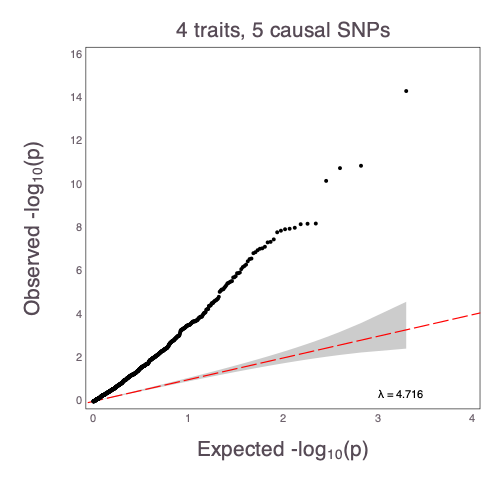

In [130]:
# includes gaussian traits
qq(pvals, dpi=100, titles="4 traits, $k causal SNPs")
display("image/png", read("qqplot.png"))